## Inverter Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import sin, cos,pi,zeros,sqrt
from sklearn.preprocessing import normalize
from numpy.linalg import multi_dot,pinv,inv,svd,eig
from numpy import dot,matmul,diag,multiply,power

def plot_eig_values(eig):
    plt.scatter(eig.real,eig.imag)

plt.rcParams.update({
        "font.weight": "bold",  # bold fonts
        "font.size":12,
        "lines.linewidth": 2,   # thick lines
        "grid.color": "0.5",    # gray gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "savefig.dpi": 300,     # higher resolution output.
        "axes.labelsize" : 15,
        'legend.labelspacing':0.95,
    })

### Reference Frame Transformation

$$V_{dq} = V_{DQ}e^{-j\delta}$$
$$v_d + jv_q = (V_D + j V_Q)\times (cos(\delta) - jsin(\delta))$$
$$v_d + jv_q = [V_D cos(\delta) + V_Q sin(\delta)] + j [-V_D sin(\delta) + V_Q cos(\delta)]$$

In [2]:
def dq0_abc_transform(v_d,v_q,v_0,omega,t_sol):
  wt = omega*np.array(t_sol)
  one = np.ones(len(wt))
  a = cos(wt)*v_d - sin(wt)*v_q + one*v_0
  b = cos(wt-2*pi/3)*v_d -sin(wt-2*pi/3)*v_q + one*v_0
  c = cos(wt+2*pi/3)*v_d -sin(wt+2*pi/3)*v_q + one*v_0
  return np.array([a,b,c])

1000*(1/(2*np.pi*50))

3.1830988618379066

In [3]:
Rf = 0.07;
Lf = 5.2e-3;
Cf = 100e-6;
Lc = 1.5e-4;
Rc = 0.05;

Kpv,Kiv,Kpc,Kic = 3,400,5,10;

J=0.05;
D=10;
wn=2*pi*50;
wf = 10*pi;
mq = 1e-5;
Kppll = 180;
Kipll = 3200;

In [4]:
def Inverter_Controller(t,x,Pref):
    vod,voq,ild,ilq,iod,ioq,Pinv,Qinv,dwVSM,aVSM,deltaVSM,gammad,gammaq,zetad,zetaq = x
    #grid model   
    vbD,vbQ = 400*sqrt(2/3),0
    #ref setpoint
    Vdref,Vqref = 400*sqrt(2/3),0
    wn = 2*pi*50
    #Pref = 50000
    Qref = 0
    #Power calculation
    pinv = (3/2)*(vod*iod + voq*ioq)
    qinv = (3/2)*(voq*iod - vod*ioq)
    Pinv_dot = - wf*Pinv + wf*pinv 
    Qinv_dot = - wf*Qinv + wf*qinv 
    #voltage control loop
    vodrefin = Vdref + (Qref-Qinv)*mq
    voqrefin = Vqref
    #frequency control loop
    dwVSM_dot = (((Pref-Pinv)/wn)-D*(dwVSM))/J
    wVSM = wn+dwVSM
    aVSM_dot = wVSM
    deltaVSM_dot = wVSM - wn #dwVSM
    #reftransfer
    vbd,vbq = cos(deltaVSM)*vbD + sin(deltaVSM)*vbQ, -sin(deltaVSM)*vbD + cos(deltaVSM)*vbQ
    #Virtual impedance
    vodref = vodrefin - ild*Rf + ilq*wVSM*Lf
    voqref = voqrefin - ilq*Rf - ild*wVSM*Lf
    #voltage Controller
    gammad_dot = vodref - vod
    gammaq_dot = voqref - voq
    ifdref  = Kpv*(vodref - vod) + Kiv*gammad + iod - wVSM*Cf*voq
    ifqref  = Kpv*(voqref - voq) + Kiv*gammaq + ioq + wVSM*Cf*vod
    #current Controller
    zetad_dot = ifdref - ild
    zetaq_dot = ifqref - ilq
    vfdref = Kpc*(ifdref - ild) + Kic*zetad + vod - wVSM*Lf*ilq
    vfqref = Kpc*(ifqref - ilq) + Kic*zetaq + voq + wVSM*Lf*ild
    #Inverter Model
    vid,viq = np.array([vfdref,vfqref])
    #Filter Model
    ild_dot = (-Rf/Lf)*ild + wVSM*ilq + (vid - vod)/Lf
    ilq_dot = -wVSM*ild + (-Rf/Lf)*ilq + (viq - voq)/Lf
    vod_dot = wVSM*voq + (ild - iod)/Cf
    voq_dot = -wVSM*vod + (ilq - ioq)/Cf
    #Coupling Line
    iod_dot = (-Rc/Lc)*iod + wVSM*ioq + (vod - vbd)/Lc
    ioq_dot = -wVSM*iod + (-Rc/Lc)*ioq + (voq - vbq)/Lc
    
    return np.array([vod_dot,voq_dot,ild_dot,ilq_dot,iod_dot,ioq_dot,Pinv_dot,Qinv_dot,dwVSM_dot,aVSM_dot,deltaVSM_dot,gammad_dot,gammaq_dot,zetad_dot,zetaq_dot])

In [5]:
t0 = 0.0
t = 0.5
dt = 0.0001
t_eval = np.arange(t0,t,dt)
x0 = zeros(15)

In [6]:
In_soln = solve_ivp(Inverter_Controller,[t0,t],y0 = x0,t_eval=t_eval,args=[50000])
t = In_soln.t

In [7]:
vods,voqs,ilds,ilqs,iods,ioqs,pinvs,qinvs,dwVSMs,aVSMs,deltaVSMs,gammads,gammaqs,zetads,zetaqs=In_soln.y
data_nonlinear = In_soln.y

In [53]:
X0 = In_soln.y.T[-1]

#### Linearized Model

In [54]:
from Linear_Model import linear_model

vbDi,vbQi = 400*np.sqrt(2/3),0
Vdrefi,Vqrefi = 400*np.sqrt(2/3),0
wni = 2*np.pi*50
Prefi = 50000
Qrefi = 0

inp = np.array([Prefi,Qrefi,Vdrefi,Vqrefi,wni,vbDi,vbQi])

Am,Bm  = linear_model(X0)

In [10]:

#linear model

t0 = 0.0
t = 0.5
dt = 0.0001
t_eval = np.arange(t0,t,dt)
x0 = zeros(15)
def linear_model_inv(t,x):
    return np.matmul(Am,x) + np.matmul(Bm,inp) #+ np.matmul(Cm,ut)

solL = solve_ivp(linear_model_inv,[t0,t],y0 = x0,t_eval=t_eval)
vodl,voql,ildl,ilql,iodl,ioql,pinvl,qinvl,dwVSMl,aVSMl,deltaVSMl,gammadl,gammaql,zetadl,zetaql = solL.y
data_linear = solL.y

In [11]:
#Ainv,Binv,Cinv,Xinv,Xinv_dot = linear_model_math()

In [12]:
#from sympy import print_latex
#print_latex(Xinv)

### Matlab simulated data

In [13]:
data_simulation = np.loadtxt("VSM_inverter_data_ddm.txt", delimiter=",")
t,tsimm,vodr,voqr,ildr,ilqr,iodr,ioqr,pinvr,qinvr,dwr,thetar = data_simulation
data_simulation = np.delete(data_simulation, (0,1), axis=0)
data_simulation = np.delete(data_simulation,(-1),axis=1)

In [14]:
tsimu = np.delete(tsimm,(-1))

In [15]:
data_simulation.shape

(10, 5000)

In [16]:
import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='red' #blue
c2='blue' #green
n = 9

from random import randint
colors = []

for i in range(9):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

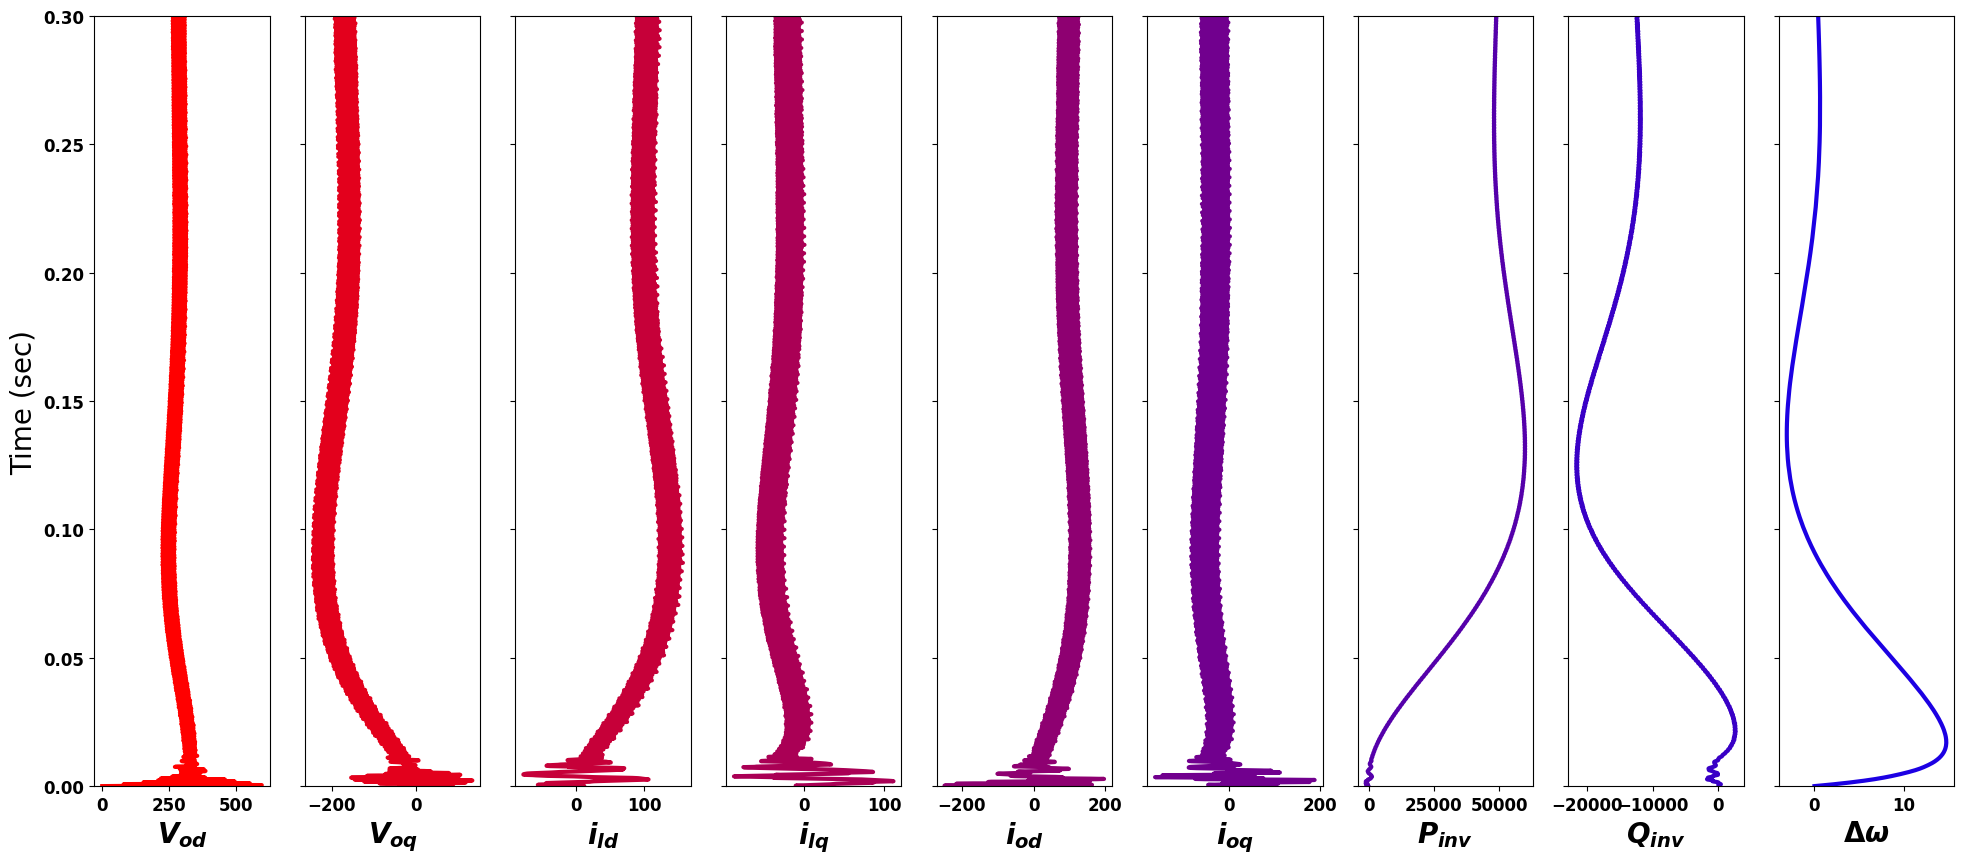

In [17]:
states = [r'$V_{od}$', r'$V_{oq}$', r'$i_{ld}$', r'$i_{lq}$', r'$i_{od}$', r'$i_{oq}$', r'$P_{inv}$', r'$Q_{inv}$', r'$\Delta \omega$']

fig, axs = plt.subplots(1, 9,figsize=(24,10),sharey=True)
for i in range(0,data_simulation.shape[0]-1):
    axs[i].plot(data_simulation[i,:],tsimu,color=colorFader(c1,c2,i/n),linestyle = "-",linewidth = 3)
    axs[i].set_ylim(0,0.3)
    axs[i].set_xlabel(states[i],fontsize = 20)
    axs[0].set_ylabel("Time (sec)",fontsize = 20)
    #axs[i].grid(linestyle='--',linewidth=2)
plt.savefig('Images/raw_data.pdf',dpi = 300, bbox_inches='tight')

#axs[0].plot(data_simulation[0,:],tsimu,linestyle = "-",linewidth = 3)
##axs[0].set_ylim(0,0.4)
#axs[0].set_xlabel(states[0],fontsize = 20)
#axs[0].set_ylabel('Time (sec)',fontsize = 20)

### Data Driven Analysis using DMD

In [18]:
t,tsim,vod,voq,ild,ilq,iod,ioq,pinv,qinv,w,theta = np.loadtxt("VSM_inverter_data_ddm.txt", delimiter=",")
data= np.loadtxt("VSM_inverter_data_ddm.txt", delimiter=",").T

In [19]:
from pydmd import BOPDMD

#when num_trial is not given then it will provide standard ODMD
#:param num_trials: Number of BOP-DMD trials to perform. If num_trials is a
#        positive integer, num_trials BOP-DMD trials are performed. Otherwise,
#        standard optimized dmd is performed.

In [20]:
datad = data.T
t = datad[0,:]
t = np.delete(t,[-1],axis=0)
Xd = datad[[2,3,4,5,6,7,8,9,10],:]
X = np.delete(Xd, [-1], axis=1) #remove last column for length consistency m-1
X_dot = np.delete(Xd, [0], axis=1) #remove first column from 2 to m
U = 50000*np.ones((Xd.shape[0],Xd.shape[1]-1))

In [21]:
dmd = BOPDMD(svd_rank=-1,compute_A=True)
dmd.fit(X,t)
Xr = dmd.reconstructed_data

c:\Users\Deependra\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydmd\bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [22]:
voddd,voqdd,ilddd,ilqdd,ioddd,ioqdd,pinvdd,qinvdd,dwdd = Xr.real #t,thetadd
td = t
data_dmd = Xr
modes_dmdbop = dmd.modes
eigs_dmdbop = dmd.eigs
A_bodmd = dmd.A
A_bdmd = dmd.atilde

### Using pysindy

In [23]:
import pysindy as ps

In [24]:
t = datad[0,:]
Xdd = Xd.T

In [25]:
differentiation_method = ps.FiniteDifference(order=5)
feature_library = ps.PolynomialLibrary(degree=1)
stlsq_optimizer = ps.STLSQ(threshold=0.05)
ssr_optimizer = ps.SSR()
# Note FROLS is similar to least-angle regression (LARS)
# and Orthogonal Matching Pursuit (OMP).
frols_optimizer = ps.FROLS()

model = ps.SINDy(
    feature_library=feature_library,
    optimizer=stlsq_optimizer,
    feature_names=["vod","voq","ild","ilq","iod","ioq","pinv","qinv","w"]
)

model.fit(Xdd, t=t)
model.print()

(vod)' = 38465.759 1 + -122.910 vod + 215.285 voq + 8665.103 ild + 115.330 ilq + -8973.729 iod + 11.236 ioq + 0.314 pinv + -0.362 qinv + 731.314 w
(voq)' = 28438.049 1 + -302.824 vod + 15.007 voq + -15.484 ild + 8626.732 ilq + -11.342 iod + -8941.878 ioq + -0.247 pinv + 0.865 qinv + -2004.548 w
(ild)' = -151193.159 1 + -130.474 vod + 20.561 voq + -244.539 ild + 1017.783 ilq + 188.825 iod + 2034.516 ioq + 3.596 pinv + -7.810 qinv + 18469.180 w
(ilq)' = -40479.375 1 + -529.138 vod + -250.868 voq + -335.683 ild + 1724.391 ilq + -2215.754 iod + -793.580 ioq + 6.993 pinv + -5.190 qinv + 21156.630 w
(iod)' = -1864572.222 1 + 4914.106 vod + -1408.499 voq + 1485.426 ild + 973.297 ilq + -1457.809 iod + 483.072 ioq + 0.251 pinv + -18.616 qinv + 20068.331 w
(ioq)' = 168392.556 1 + -2057.069 vod + 3401.224 voq + 2382.008 ild + 2394.613 ilq + -2532.369 iod + -500.375 ioq + 18.539 pinv + -8.174 qinv + 52560.769 w
(pinv)' = 812481.677 1 + -2007.077 vod + 86.794 voq + 1273.006 ild + 2085.048 ilq + 130

In [26]:
x0 = np.array([0,0,0,0,0,0,0,0,0])
sim = model.simulate(x0, t=t)
vodsin,voqsin,ildsin,ilqsin,iodsin,ioqsin,pinvsin,qinvsin,wsin = sim.T
t_sin = t
data_sindy = sim.T

In [27]:
Amp = model.coefficients()[:,[1,2,3,4,5,6,7,8,9]]
eig_sind, mode_sind = eig(Amp)

In [28]:
eig_sind

array([-119.14987975+6873.25225595j, -119.14987975-6873.25225595j,
       -170.5946647 +4470.13001334j, -170.5946647 -4470.13001334j,
        -29.97392717+2896.96461927j,  -29.97392717-2896.96461927j,
       -150.88926962   +0.j        ,   -2.73944098   +0.j        ,
        -28.21207231   +0.j        ])

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

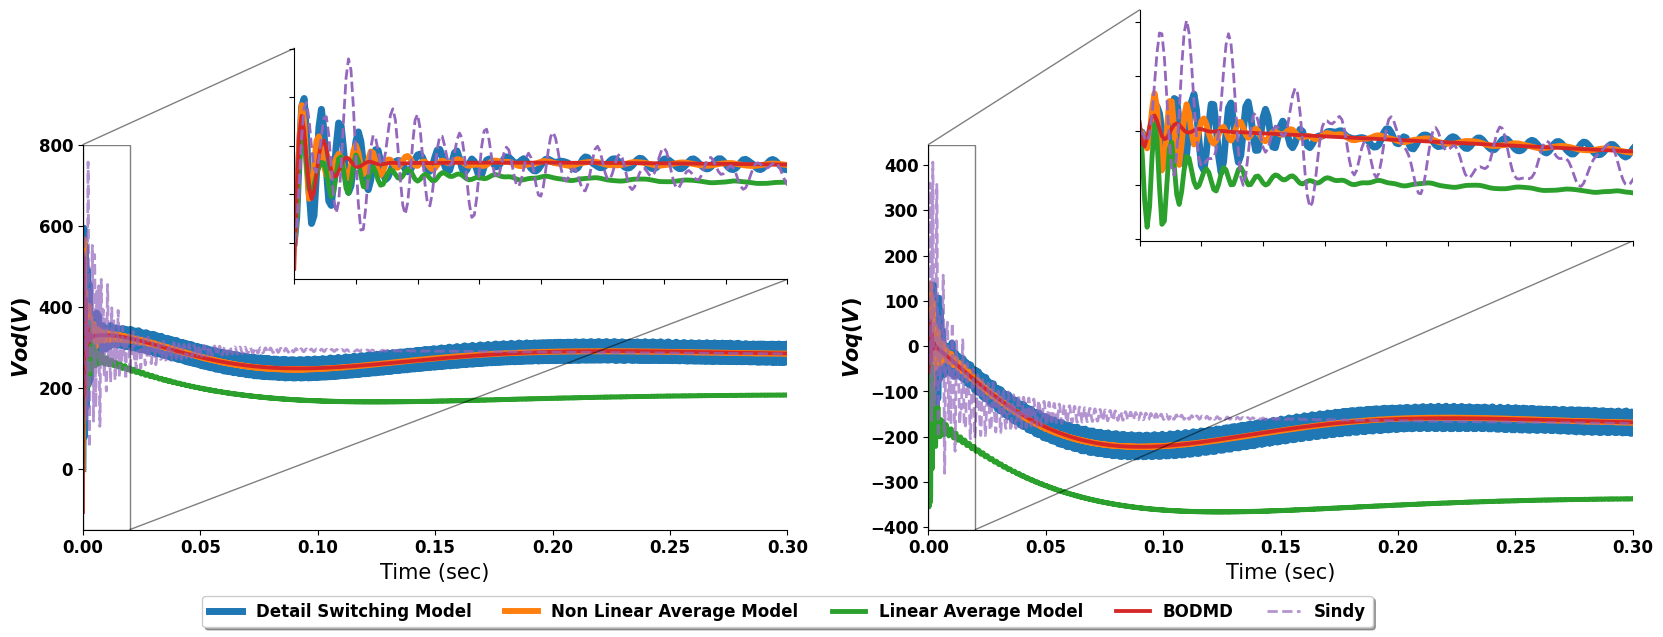

In [30]:
xlimit = [0.0,0.3]# #0.45
xlimitm = [0.0,0.02]
LS = ['-','-','-','-','--']
LW = [5,4.25,3.5,2.75,2]

fig, [axs1,axs2] = plt.subplots(1,2,figsize=(20,5))

axs1.plot(tsimm,vodr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
axs1.plot(t_eval,vods,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
axs1.plot(t_eval,vodl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
axs1.plot(td,voddd,label = "BODMD",linestyle = LS[3],linewidth = LW[3])
axs1.plot(t_sin,vodsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
axs1.set_xlim(xlimit)
axs1.set_ylabel("$Vod (V)$")
axs1.set_xlabel("Time (sec)")

sub_ax1 = axs1.inset_axes(
    [0.3, 0.65, 0.7, 0.60],
    xlim= xlimitm, xticklabels=[], yticklabels=[])


sub_ax1.plot(tsimm,vodr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
sub_ax1.plot(t_eval,vods,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
sub_ax1.plot(t_eval,vodl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
sub_ax1.plot(td,voddd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
sub_ax1.plot(t_sin,vodsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4])
sub_ax1.set_xlim(xlimitm)
axs1.indicate_inset_zoom(sub_ax1, edgecolor="black")

#second axis
axs2.plot(tsimm,voqr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
axs2.plot(t_eval,voqs,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
axs2.plot(t_eval,voql,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
axs2.plot(td,voqdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
axs2.plot(t_sin,voqsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
axs2.set_xlim(xlimit)
axs2.set_ylabel("$Voq (V)$")
axs2.set_xlabel("Time (sec)")

sub_ax2 = axs2.inset_axes(
    [0.3, 0.75, 0.7, 0.60],
    xlim= xlimitm, xticklabels=[], yticklabels=[])


sub_ax2.plot(tsimm,voqr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
sub_ax2.plot(t_eval,voqs,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
sub_ax2.plot(t_eval,voql,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
sub_ax2.plot(td,voqdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
sub_ax2.plot(t_sin,voqsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4])
sub_ax2.set_xlim(xlimitm)
axs2.indicate_inset_zoom(sub_ax2, edgecolor="black")

#axs1.legend(ncol = 3)
axs1.legend(loc='upper center', bbox_to_anchor=(1, -0.15),fancybox=True, shadow=True, ncol=6)

plt.savefig('Images/dyanmics_vodq.pdf',dpi = 300, bbox_inches='tight')

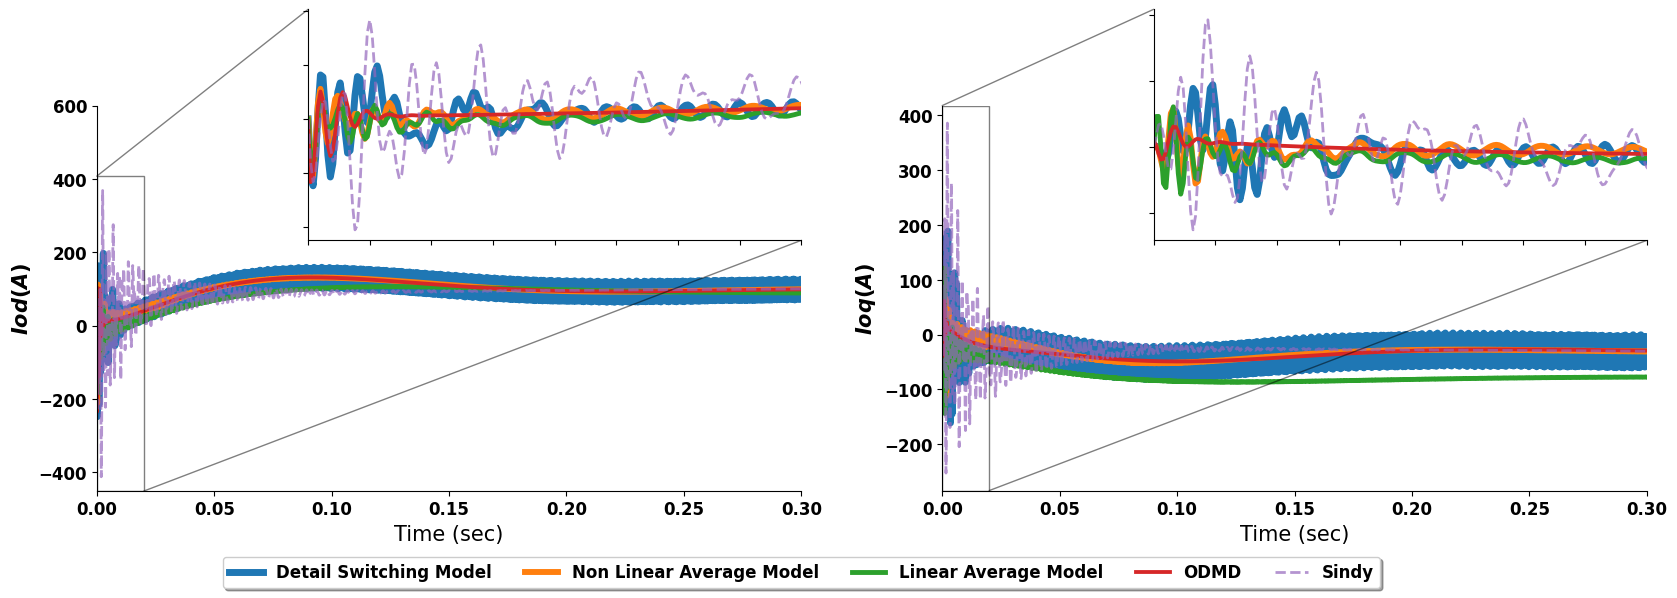

In [31]:
fig, [axs1,axs2] = plt.subplots(1,2,figsize=(20,5))
axs1.plot(tsimm,iodr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
axs1.plot(t_eval,iods,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
axs1.plot(t_eval,iodl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
axs1.plot(td,ioddd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
axs1.plot(t_sin,iodsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
axs1.set_ylabel("$Iod (A)$")
axs1.set_xlim(xlimit)
axs1.set_xlabel("Time (sec)")
axs1.set_ylim(-450,600)

sub_ax1 = axs1.inset_axes(
    [0.3, 0.65, 0.7, 0.60],
    xlim= xlimitm, xticklabels=[], yticklabels=[])


sub_ax1.plot(tsimm,iodr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
sub_ax1.plot(t_eval,iods,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
sub_ax1.plot(t_eval,iodl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
sub_ax1.plot(td,ioddd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
sub_ax1.plot(t_sin,iodsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
sub_ax1.set_xlim(xlimitm)
axs1.indicate_inset_zoom(sub_ax1, edgecolor="black")

#axis 2

axs2.plot(tsimm,ioqr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
axs2.plot(t_eval,ioqs,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
axs2.plot(t_eval,ioql,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
axs2.plot(td,ioqdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
axs2.plot(t_sin,ioqsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
axs2.set_ylabel("$Ioq (A)$")
axs2.set_xlabel("Time (sec)")
axs2.set_xlim(xlimit)

sub_ax2 = axs2.inset_axes(
    [0.3, 0.65, 0.7, 0.60],
    xlim= xlimitm, xticklabels=[], yticklabels=[])

sub_ax2.plot(tsimm,ioqr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
sub_ax2.plot(t_eval,ioqs,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
sub_ax2.plot(t_eval,ioql,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
sub_ax2.plot(td,ioqdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
sub_ax2.plot(t_sin,ioqsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
sub_ax2.set_xlim(xlimitm)
axs2.indicate_inset_zoom(sub_ax2, edgecolor="black")
axs1.legend(loc='upper center', bbox_to_anchor=(1, -0.15),fancybox=True, shadow=True, ncol=6)
plt.savefig('Images/dyanmics_iodq.pdf',dpi = 300, bbox_inches='tight')

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Deependra\AppData\Local\Temp\ipykernel_12596\1820911336.py:9: SyntaxWarning: invalid escape sequence '\D'
  axs1.set_ylabel("$\Delta \omega (rads^{-1})$")


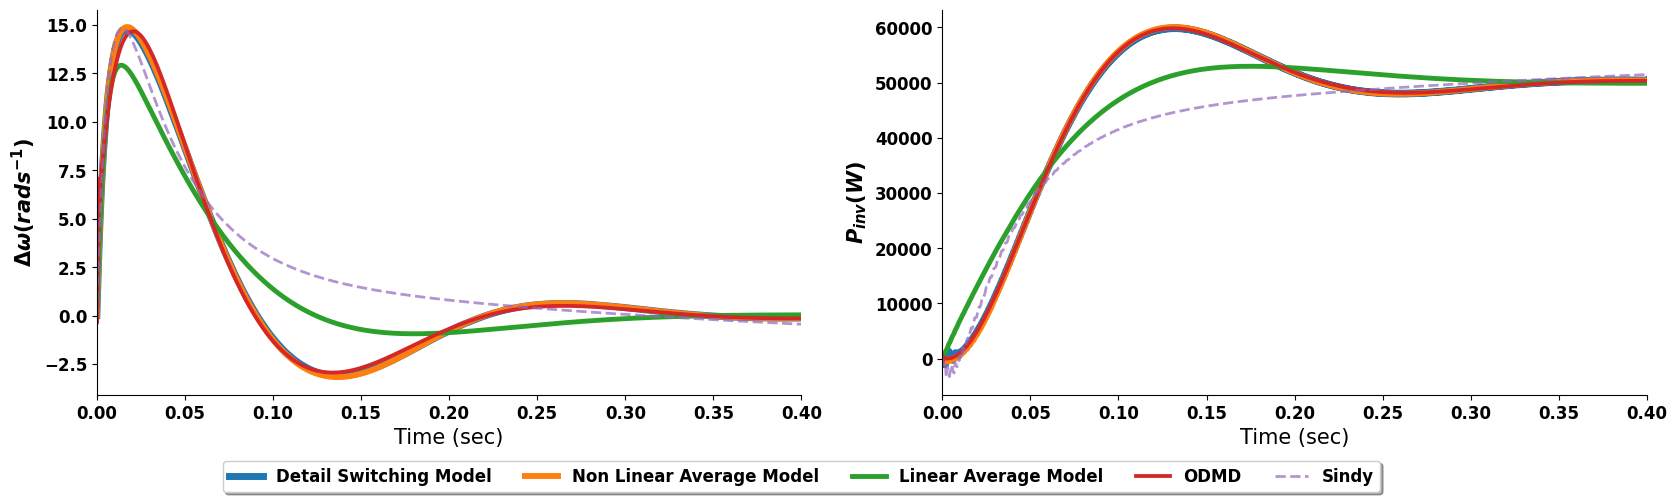

In [32]:
xlimit = [0,0.4]
xlimitm= [0,0.05]
fig, [axs1,axs2] = plt.subplots(1,2,figsize=(20,5))
axs1.plot(tsimm,dwr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
axs1.plot(t_eval,dwVSMs, label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
axs1.plot(t_eval,dwVSMl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
axs1.plot(td,dwdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
axs1.plot(t_sin,wsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
axs1.set_ylabel("$\Delta \omega (rads^{-1})$")
axs1.set_xlim(xlimit)
axs1.set_xlabel("Time (sec)")



#sub_ax1 = axs1.inset_axes(
#    [0.3, 0.55, 0.7, 0.60],
#    xlim= xlimitm, xticklabels=[], yticklabels=[])

#sub_ax1.plot(tsimm,dwr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
#sub_ax1.plot(t_eval,dwVSMs, label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
#sub_ax1.plot(t_eval,dwVSMl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
#sub_ax1.plot(td,dwdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
#sub_ax1.plot(t_sin,wsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
#sub_ax1.set_xlim(xlimitm)
#axs1.indicate_inset_zoom(sub_ax1, edgecolor="black")

#second axis
axs2.plot(tsimm,pinvr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
axs2.plot(t_eval, pinvs,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
axs2.plot(t_eval,pinvl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
axs2.plot(td,pinvdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
axs2.plot(t_sin,pinvsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
axs2.set_ylabel("$P_{inv} (W)$")
axs2.set_xlim(xlimit)
axs2.set_xlabel("Time (sec)")

#sub_ax2 = axs2.inset_axes(
#    [0.3, 0.05, 0.7, 0.60],
#    xlim= xlimitm, xticklabels=[], yticklabels=[])

#sub_ax2.plot(tsimm,pinvr,label="Detail Switching Model",linestyle = LS[0],linewidth = LW[0])
#sub_ax2.plot(t_eval, pinvs,label = "Non Linear Average Model",linestyle = LS[1],linewidth = LW[1])
#sub_ax2.plot(t_eval,pinvl,label = "Linear Average Model",linestyle = LS[2],linewidth = LW[2])
#sub_ax2.plot(td,pinvdd,label = "ODMD",linestyle = LS[3],linewidth = LW[3])
#sub_ax2.plot(t_sin,pinvsin,label = "Sindy",linestyle = LS[4],linewidth = LW[4],alpha = 0.7)
#sub_ax2.set_xlim(xlimitm)
#axs2.indicate_inset_zoom(sub_ax2, edgecolor="black")

axs1.legend(loc='upper center', bbox_to_anchor=(1, -0.15),fancybox=True, shadow=True, ncol=6)
plt.savefig('Images/dyanmics_wp.pdf',dpi = 300, bbox_inches='tight')

In [48]:
A_Linear = normalize(Am,norm='max')
A_bdmd = normalize(A_bdmd.real,norm='max')
A_sind = normalize(Amp,norm='max')
A_linear = A_Linear[:9,:9]


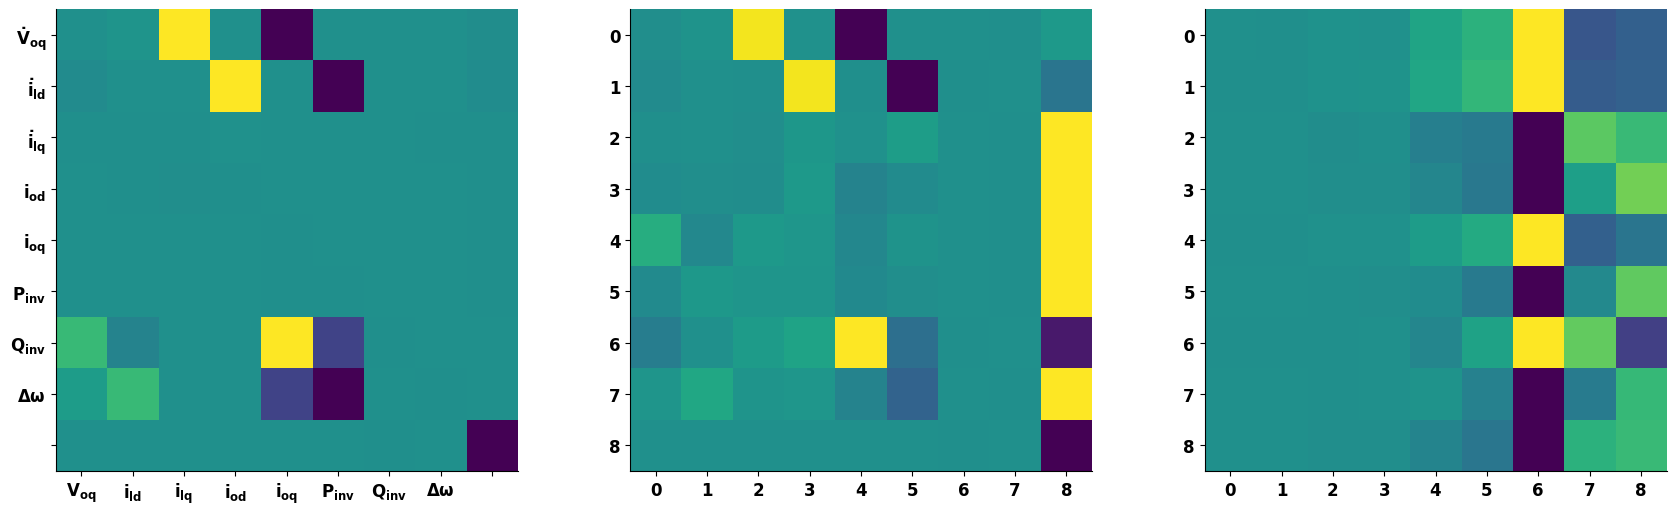

In [34]:
params = {'mathtext.default': 'regular' }  # Allows tex-style title & labels
plt.rcParams.update(params)
fig, axs = plt.subplots(1, 3,figsize=(21,6))

yticks =  [r'$\dot{V}_{od}$', r'$\dot{V}_{oq}$', r'$\dot{i}_{ld}$', r'$\dot{i}_{lq}$', r'$i_{od}$', r'$i_{oq}$', r'$P_{inv}$', r'$Q_{inv}$', r'$\Delta \omega$']

xticks = [r'$V_{od}$', r'$V_{oq}$', r'$i_{ld}$', r'$i_{lq}$', r'$i_{od}$', r'$i_{oq}$', r'$P_{inv}$', r'$Q_{inv}$', r'$\Delta \omega$']


axs[0].imshow(A_linear)
axs[0].set_xticklabels(xticks)
axs[0].set_yticklabels(yticks)
axs[1].imshow(A_sind)
axs[2].imshow(A_bdmd)

In [56]:
eigs_linear,modes_linear = np.linalg.eig(Am)

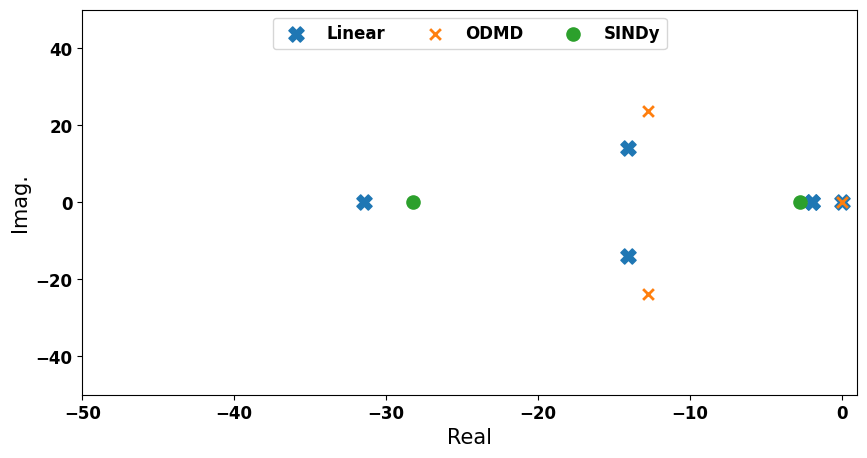

In [57]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(eigs_linear.real,eigs_linear.imag,label='Linear',marker='X',s=120)
ax.scatter(eigs_dmdbop.real,eigs_dmdbop.imag,label='ODMD',marker='x',s=60)
ax.scatter(eig_sind.real,eig_sind.imag,label='SINDy',marker='o',s=90)
ax.set_xlabel("Real")
ax.set_ylabel("Imag.")
ax.set_xbound(-50,1)
ax.set_ybound(-50,50)
ax.legend(loc='upper center',ncol = 3)
#ax.grid(True, linestyle='--',linewidth = 1)
plt.savefig('Images/eigenvalues.pdf',dpi = 300, bbox_inches='tight')

### Error Analysis

In [37]:
data_nonlinear = np.delete(data_nonlinear, (9,10,11,12,13,14), axis=0) # removing unrequired rows
data_linear = np.delete(data_linear, (9,10,11,12,13,14), axis=0)
data_simulation = np.delete(data_simulation,(9),axis=0)
data_dmd = data_dmd.real
data_sind = np.delete(data_sindy,(-1), axis = 1)

In [38]:
tp = 'max'
dn_nonlinear = normalize(data_nonlinear,norm= tp,axis=1)
dn_simulation = normalize(data_simulation,norm=tp,axis=1)
dn_linear=normalize(data_linear,norm=tp,axis=1)
dn_dmd=normalize(data_dmd,norm=tp,axis=1)
dn_sindy=normalize(data_sind,norm=tp,axis=1)

In [39]:
mse_nl = ((dn_simulation - dn_nonlinear)**2).mean(axis=1)
mse_li = ((dn_simulation - dn_linear)**2).mean(axis=1)
mse_dmd = ((dn_simulation - dn_dmd)**2).mean(axis=1)
mse_sindy = ((dn_simulation - dn_sindy)**2).mean(axis=1)

rmse_nl = np.sqrt(np.mean((dn_simulation - dn_nonlinear)**2,axis = 1))
rmse_li = np.sqrt(np.mean((dn_simulation - dn_linear)**2,axis = 1))
rmse_dmd = np.sqrt(np.mean((dn_simulation - dn_dmd)**2,axis = 1))
rmse_sindy = np.sqrt(np.mean((dn_simulation - dn_sindy)**2,axis = 1))

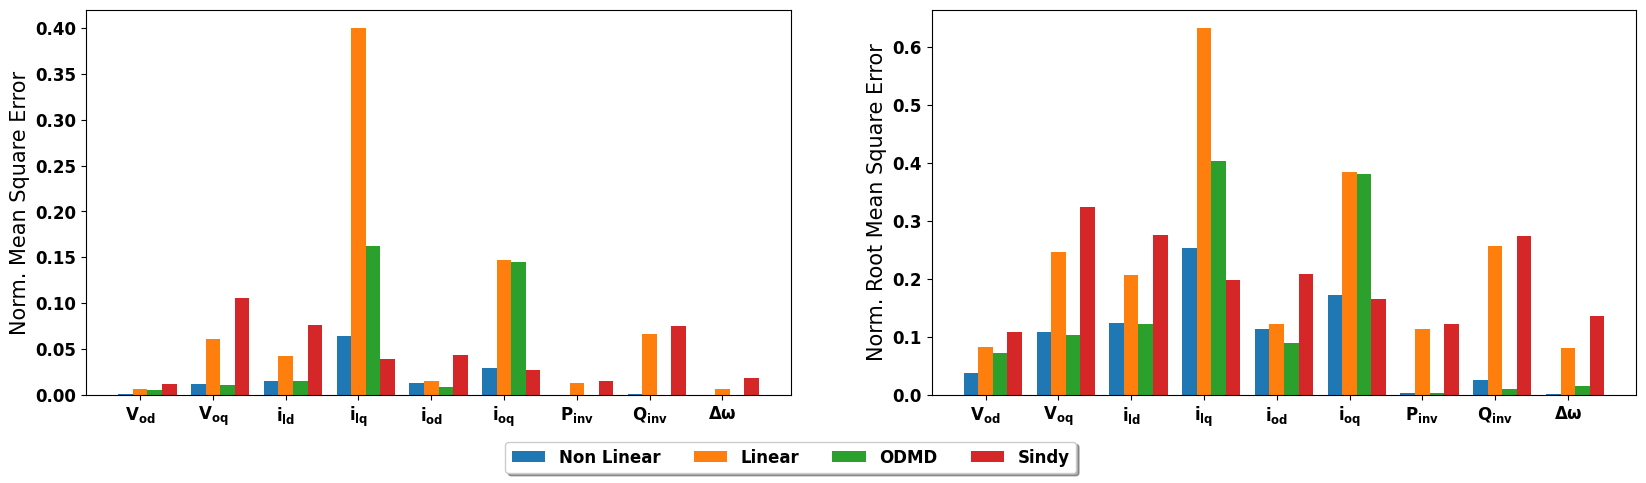

In [40]:
params = {'mathtext.default': 'regular' }  # Allows tex-style title & labels
plt.rcParams.update(params)

states = [r'$V_{od}$', r'$V_{oq}$', r'$i_{ld}$', r'$i_{lq}$', r'$i_{od}$', r'$i_{oq}$', r'$P_{inv}$', r'$Q_{inv}$', r'$\Delta \omega$']
MSE = {
    'Non Linear': mse_nl,
    'Linear': mse_li,
    'ODMD': mse_dmd,
    'Sindy':mse_sindy
}

RMSE = {
    'Non Linear': rmse_nl,
    'Linear': rmse_li,
    'ODMD': rmse_dmd,
    'Sindy': rmse_sindy
}

x1 =x2= np.arange(len(states))  # the label locations
width = 0.2  # the width of the bars
multiplier1=multiplier2 = 0

#fig, ax = plt.subplots(figsize=(9,4))
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,5))

for attribute, measurement in MSE.items():
    offset = width * multiplier1
    rects = ax1.bar(x1 + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier1 += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Norm. Mean Square Error')
ax1.set_xticks(x1 + width, states)
#ax1.legend(loc='upper left', ncols=3)
ax1.legend(loc='upper center', bbox_to_anchor=(1, -0.1),fancybox=True, shadow=True, ncol=6)

for attribute, measurement in RMSE.items():
    offset = width * multiplier2
    rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier2 += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Norm. Root Mean Square Error')
ax2.set_xticks(x2 + width, states)
#ax2.legend(loc='upper left', ncols=3)
#ax1.grid(linestyle='--',linewidth=1)
#ax2.grid(linestyle='--',linewidth=1)


plt.savefig('Images/erro_compare.pdf',dpi = 300, bbox_inches='tight')
plt.show()

In [41]:
from sklearn.metrics import r2_score

r_nl =r2_score(dn_nonlinear,dn_simulation)
r_dmd = r2_score(dn_dmd,dn_simulation)
r_lin = r2_score(dn_simulation,dn_linear)
r_sin = r2_score(dn_sindy,dn_simulation)

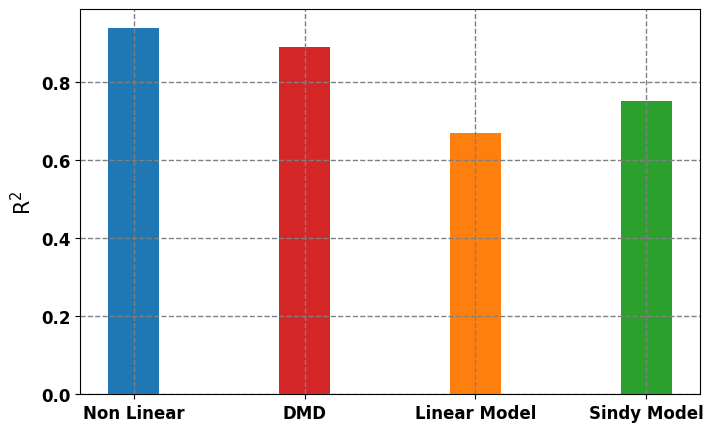

In [42]:
fig,ax = plt.subplots(figsize=(8,5))

fruits = ['Non Linear', 'DMD', 'Linear Model','Sindy Model']
counts = [r_nl, r_dmd, r_lin, r_sin]
bar_labels = [ 'Non Linear', 'DMD', 'Linear Model','Sindy Model']
bar_colors = [ 'tab:blue', 'tab:red', 'tab:orange','tab:green']

ax.bar(fruits, counts,width=0.3, label=bar_labels, color=bar_colors)

ax.set_ylabel('$R^2$')
ax.grid(linestyle='--',linewidth=1)

plt.savefig('Images/r_square.jpg',dpi = 300, bbox_inches='tight')